In [4]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

import pickle
from tqdm.notebook import tqdm

https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=CAD&limit=500

In [7]:
def train_test_split(df, test_size=0.2):
  split_row = len(df) - int(test_size * len(df))
  train_data = df.iloc[:split_row]
  test_data = df.iloc[split_row:]
  return train_data, test_data

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

def normalise_zero_base(df):
  # print(df.info())
  # print(df.head())
  return df / df.iloc[0] - 1

def normalise_min_max(df):
  return (df - df.min()) / (data.max() - df.min())

def extract_window_data(df, window_len=5, zero_base=True):
  window_data = []
  dates = []
  # extract window_len points for win segment
  for idx in range(len(df) - window_len):
      tmp = df[idx: (idx + window_len)].copy()
      # print(tmp)
      if zero_base:
          tmp = normalise_zero_base(tmp)
      dates.append(tmp.index)
      window_data.append(tmp.values)
  return np.array(window_data), dates

def prepare_data(df, target_col, window_len=10, pred_horizon=5, zero_base=True, test_size=0.2):
  # split data
  train_data, test_data = train_test_split(df, test_size=test_size)

  # process data get tensors by win
  X_train, train_dates = extract_window_data(train_data, window_len, zero_base)
  X_test, test_dates = extract_window_data(test_data, window_len, zero_base)
  
  # extract targets - the point after each win_len segment + offset of predict_horizon
  y_train = train_data[target_col][window_len + pred_horizon:]
  y_test = test_data[target_col][window_len + pred_horizon:]

  # make offset by value of horizon
  X_train = X_train[:-pred_horizon]
  X_test = X_test[:-pred_horizon]
  train_dates = train_dates[:-pred_horizon]
  test_dates = test_dates[:-pred_horizon]
  train_data = train_data[:-pred_horizon]
  test_data = test_data[:-pred_horizon]
  
  # for i in range(20):
  #   print()
  #   print('test dates: ', test_dates[-i])
  #   print('ytest: ', y_test[-i:-i+1])
  
  y_trian = y_train.values
  y_test = y_test.values

  if zero_base:
      y_train = y_train / train_data[target_col][:-window_len].values - 1
      y_test = y_test / test_data[target_col][:-window_len].values - 1

  return train_data, test_data, X_train, X_test, y_train, y_test, train_dates, test_dates

def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
  model = Sequential()
  model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))

  model.compile(loss=loss, optimizer=optimizer)
  return model

def save_model(model, file_name):
    """
    Save model in pickle format
    :param model: training model
    :param file_name: String
        Path to the model file
    """
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)
        
def load_model(file_name):
    """
    Load model from file
    :param file_name: String
        Path to the model file
    :return: predictive model
    """
    with open(file_name, 'rb') as file:
        return pickle.load(file)

(501, 6)
               high      low     open  volumefrom  volumeto    close
time                                                                
2019-08-07  0.01975  0.01877  0.01971  2377149.41  45675.22  0.01888
2019-08-08  0.01908  0.01840  0.01888  2308485.15  43522.55  0.01845
2019-08-09  0.01854  0.01756  0.01845  2351560.73  42278.85  0.01773
2019-08-10  0.01828  0.01772  0.01773  2388120.21  42981.27  0.01824
2019-08-11  0.01898  0.01824  0.01824  2107135.75  39187.25  0.01872
2019-08-12  0.01875  0.01850  0.01872  1612897.03  30028.15  0.01856
2019-08-13  0.01927  0.01840  0.01856  2018275.26  37904.58  0.01920
2019-08-14  0.01978  0.01816  0.01920  2828543.26  53860.56  0.01859
2019-08-15  0.01883  0.01798  0.01859  2833953.91  52052.35  0.01825
2019-08-16  0.01849  0.01763  0.01825  2614078.68  47257.69  0.01789
(401, 6) (100, 6)
Epoch 1/20
13/13 [==============================] - 1s 4ms/step - loss: 0.0095
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 2s 3ms/step - loss: 0.0445
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0381
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0378
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0248
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0304
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0261
Epoch 7/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0330
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0327
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0268
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0290
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0205
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0260
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
                high       low      open    volumefrom  volumeto     close
time                                                                      
2019-08-07  0.000088  0.000082  0.000087  8.347194e+08  70893.90  0.000084
2019-08-08  0.000087  0.000083  0.000084  5.884635e+08  49871.24  0.000083
2019-08-09  0.000086  0.000083  0.000083  4.642146e+08  39230.82  0.000084
2019-08-10  0.000089  0.000084  0.000084  4.700497e+08  40869.27  0.000089
2019-08-11  0.000090  0.000086  0.000089  2.928147e+08  25734.51  0.000087
2019-08-12  0.000089  0.000087  0.000087  2.299081e+08  20181.72  0.000088
2019-08-13  0.000093  0.000087  0.000088  4.832401e+08  43742.98  0.000092
2019-08-14  0.000101  0.000092  0.000092  7.282475e+08  70125.86  0.000100
2019-08-15  0.000105  0.000096  0.000100  8.429791e+08  84438.15  0.000097
2019-08-16  0.000102  0.000095  0.000097  6.350408e+08  62357.48  0.000097
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 4ms/step - loss: 0.0205
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 5/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 6/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0169
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 8/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0187
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
              high     low    open  volumefrom  volumeto   close
time                                                            
2019-08-07  0.9021  0.8475  0.8919    14640.04  13046.64  0.8912
2019-08-08  0.8987  0.8573  0.8912     9254.37   8280.92  0.8948
2019-08-09  0.9067  0.8780  0.8948     8245.31   7352.39  0.8917
2019-08-10  0.9452  0.8886  0.8917     8232.17   7350.00  0.8928
2019-08-11  0.8945  0.8595  0.8928     5456.25   4873.05  0.8931
2019-08-12  0.9058  0.8846  0.8931     4948.76   4414.94  0.8921
2019-08-13  0.9390  0.8849  0.8921     9597.14   8587.28  0.8948
2019-08-14  0.9699  0.8883  0.8948    14128.06  12674.76  0.8971
2019-08-15  0.9133  0.8270  0.8971    20347.72  18325.33  0.9006
2019-08-16  0.9176  0.8491  0.9006    13107.10  11819.19  0.9017
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 8.1495e-04
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 7.4842e-04
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 8.6834e-04
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 8.4516e-04
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 6.3067e-04
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 3.9662e-04
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 5.4196e-04
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 4.3350e-04
Epoch 13/20
13/13

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
             high    low   open  volumefrom  volumeto  close
time                                                        
2019-08-07  64.59  59.45  63.57      298.99  18539.76  62.01
2019-08-08  63.49  61.02  62.01      310.52  19388.64  62.44
2019-08-09  63.59  61.35  62.44      197.67  12400.35  62.73
2019-08-10  66.40  62.88  62.73      108.76   6870.72  63.17
2019-08-11  63.54  60.87  63.17      104.14   6607.91  63.45
2019-08-12  64.35  63.16  63.45      110.32   7067.62  64.06
2019-08-13  67.24  62.39  64.06      152.04   9796.54  64.43
2019-08-14  70.70  64.10  64.43      232.21  15303.86  65.91
2019-08-15  67.35  61.03  65.91      314.73  20848.88  66.24
2019-08-16  69.20  61.81  66.24      207.96  13871.59  66.70
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 4ms/step - loss: 0.0098
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 7/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 9/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 11/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
              high     low    open  volumefrom    volumeto   close
time                                                              
2019-08-07  106.93  101.02  106.43    53879.96  5710638.97  105.99
2019-08-08  106.47  101.77  105.99    42854.45  4546142.49  106.08
2019-08-09  107.53  103.73  106.08    33498.14  3537546.48  105.60
2019-08-10  111.98  105.00  105.60    30778.85  3249889.78  105.59
2019-08-11  105.73  101.60  105.59    24501.97  2585218.32  105.51
2019-08-12  107.16  103.76  105.51    20685.34  2179665.95  105.37
2019-08-13  111.09  105.45  105.37    29334.89  3125535.15  106.55
2019-08-14  115.57  104.72  106.55    48505.79  5124767.95  105.65
2019-08-15  107.69   97.89  105.65    64329.49  6830587.17  106.18
2019-08-16  108.05  100.68  106.18    59425.64  6312943.77  106.23
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 4ms/step - loss: 0.0011 
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 8.2957e-04
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 7.0866e-04
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 6.8766e-04
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 5.3144e-04
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 4.2634e-04
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 4.3673e-04
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 5.0635e-04
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 4.6851e-04
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 3.6629e-04
Epoch 11/20
13/13 [==============================] - 0s 4ms/step - loss: 3.9166e-04
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 4.2141e-04
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
                high       low      open   volumefrom   volumeto     close
time                                                                      
2019-08-07  0.005086  0.004850  0.004959  11952774.34   59341.97  0.004959
2019-08-08  0.005202  0.004946  0.004959  10205718.45   51544.35  0.005060
2019-08-09  0.005412  0.005053  0.005060  11171313.26   59027.37  0.005330
2019-08-10  0.005582  0.005225  0.005330   9115747.71   49343.66  0.005436
2019-08-11  0.005445  0.005168  0.005436   7148857.57   37800.08  0.005175
2019-08-12  0.005326  0.005173  0.005175   5937276.62   31312.67  0.005306
2019-08-13  0.005494  0.005299  0.005306   8118934.38   43768.91  0.005357
2019-08-14  0.006095  0.005340  0.005357  18853570.36  108566.47  0.005974
2019-08-15  0.006405  0.005859  0.005974  20414162.47  124244.46  0.005899
2019-08-16  0.006203  0.005891  0.005899  13256436.75   79938.27  0.005980
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 2s 4ms/step - loss: 0.0408
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0331
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0341
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0265
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0231
Epoch 6/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0288
Epoch 7/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0264
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0210
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0258
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0257
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0235
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
                high       low      open    volumefrom  volumeto     close
time                                                                      
2019-08-07  0.000099  0.000093  0.000098  1.537037e+08  14640.04  0.000094
2019-08-08  0.000097  0.000093  0.000094  9.734200e+07   9254.37  0.000093
2019-08-09  0.000096  0.000093  0.000093  8.702979e+07   8245.31  0.000095
2019-08-10  0.000100  0.000094  0.000095  8.446866e+07   8232.17  0.000099
2019-08-11  0.000101  0.000097  0.000099  5.540407e+07   5456.25  0.000097
2019-08-12  0.000099  0.000097  0.000097  5.034079e+07   4948.76  0.000098
2019-08-13  0.000104  0.000098  0.000098  9.479103e+07   9597.14  0.000103
2019-08-14  0.000112  0.000103  0.000103  1.317270e+08  14128.06  0.000111
2019-08-15  0.000117  0.000106  0.000111  1.826344e+08  20347.72  0.000108
2019-08-16  0.000114  0.000105  0.000108  1.203830e+08  13107.10  0.000107
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 4ms/step - loss: 0.0219
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 7/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 9/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0148
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
             high    low   open  volumefrom  volumeto  close
time                                                        
2019-08-07  1.138  1.068  1.121    70893.90  79552.23  1.122
2019-08-08  1.123  1.072  1.122    49871.24  55733.78  1.118
2019-08-09  1.137  1.103  1.118    39230.82  43995.24  1.121
2019-08-10  1.187  1.114  1.121    40869.27  45774.50  1.120
2019-08-11  1.123  1.078  1.120    25734.51  28814.38  1.120
2019-08-12  1.137  1.106  1.120    20181.72  22621.95  1.121
2019-08-13  1.176  1.107  1.121    43742.98  48887.15  1.118
2019-08-14  1.208  1.103  1.118    70125.86  78166.54  1.115
2019-08-15  1.126  1.023  1.115    84438.15  93756.79  1.110
2019-08-16  1.129  1.045  1.110    62357.48  69152.42  1.109
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 4ms/step - loss: 0.0021
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 7/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 7.4169e-04
Epoch 9/20
13/13 [==============================] - 0s 4ms/step - loss: 7.4095e-04
Epoch 10/20
13/13 [==============================] - 0s 4ms/step - loss: 6.9421e-04
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 4.8698e-04
Epoch 12/20
13/13 [==============================] - 0s 4ms/step - loss: 5.7795e-04
Epoch 13/20
13/13 [==========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
             high    low   open  volumefrom  volumeto  close
time                                                        
2019-08-07  72.48  66.71  71.27      298.99  20804.04  69.58
2019-08-08  70.95  68.19  69.58      310.52  21667.84  69.78
2019-08-09  71.31  68.80  69.78      197.67  13906.32  70.35
2019-08-10  74.37  70.42  70.35      108.76   7695.36  70.76
2019-08-11  71.15  68.15  70.76      104.14   7398.74  71.05
2019-08-12  72.13  70.80  71.05      110.32   7922.19  71.81
2019-08-13  75.15  69.72  71.81      152.04  10948.62  72.01
2019-08-14  78.80  71.45  72.01      232.21  17058.61  73.46
2019-08-15  74.78  67.77  73.46      314.73  23149.78  73.55
2019-08-16  76.74  68.54  73.55      207.96  15383.15  73.97
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 2s 4ms/step - loss: 0.0031
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 9/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
              high     low    open  volumefrom    volumeto   close
time                                                              
2019-08-07  119.99  113.36  119.32    53879.96  6408083.76  118.93
2019-08-08  118.99  113.73  118.93    42854.45  5080557.54  118.55
2019-08-09  120.59  116.33  118.55    33498.14  3967166.45  118.43
2019-08-10  125.42  117.60  118.43    30778.85  3639949.65  118.26
2019-08-11  118.38  113.76  118.26    24501.97  2894613.81  118.14
2019-08-12  120.11  116.30  118.14    20685.34  2443215.64  118.11
2019-08-13  124.15  117.85  118.11    29334.89  3493097.56  119.08
2019-08-14  128.82  116.73  119.08    48505.79  5712377.10  117.77
2019-08-15  119.57  108.70  117.77    64329.49  7584414.81  117.90
2019-08-16  119.82  111.65  117.90    59425.64  7000850.10  117.81
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 3ms/step - loss: 0.0010 
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 9.7956e-04
Epoch 3/20
13/13 [==============================] - 0s 4ms/step - loss: 8.4202e-04
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 6.9264e-04
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 6.0955e-04
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 6.7089e-04
Epoch 7/20
13/13 [==============================] - 0s 4ms/step - loss: 4.0117e-04
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 6.4664e-04
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 5.8244e-04
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 5.4528e-04
Epoch 11/20
13/13 [==============================] - 0s 4ms/step - loss: 4.1898e-04
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 3.0637e-04
Epoc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
                high       low      open   volumefrom  volumeto     close
time                                                                     
2019-08-07  0.000072  0.000070  0.000071  11960814.65    848.88  0.000071
2019-08-08  0.000074  0.000071  0.000071  11555744.02    830.40  0.000073
2019-08-09  0.000077  0.000073  0.000073  10870330.25    814.87  0.000076
2019-08-10  0.000079  0.000074  0.000076  11108098.68    849.66  0.000077
2019-08-11  0.000077  0.000073  0.000077  10410787.45    778.40  0.000073
2019-08-12  0.000075  0.000073  0.000073  10660125.20    788.69  0.000074
2019-08-13  0.000077  0.000074  0.000074  10454311.25    783.70  0.000075
2019-08-14  0.000083  0.000074  0.000075  12062720.13    936.18  0.000082
2019-08-15  0.000087  0.000079  0.000082  11443777.57    943.82  0.000080
2019-08-16  0.000085  0.000080  0.000080  10532320.09    859.88  0.000081
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 4ms/step - loss: 0.0184
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0211
Epoch 3/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0178
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
                high       low      open    volumefrom  volumeto     close
time                                                                      
2019-08-07  0.000001  0.000001  0.000001  2.227266e+08    298.99  0.000001
2019-08-08  0.000001  0.000001  0.000001  2.316666e+08    310.52  0.000001
2019-08-09  0.000001  0.000001  0.000001  1.469022e+08    197.67  0.000001
2019-08-10  0.000001  0.000001  0.000001  7.912549e+07    108.76  0.000001
2019-08-11  0.000001  0.000001  0.000001  7.500240e+07    104.14  0.000001
2019-08-12  0.000001  0.000001  0.000001  8.027982e+07    110.32  0.000001
2019-08-13  0.000001  0.000001  0.000001  1.091255e+08    152.04  0.000001
2019-08-14  0.000002  0.000001  0.000001  1.572502e+08    232.21  0.000002
2019-08-15  0.000002  0.000001  0.000002  2.055737e+08    314.73  0.000001
2019-08-16  0.000002  0.000001  0.000001  1.392808e+08    207.96  0.000001
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 3ms/step - loss: 0.0148
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0110
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 9/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 10/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0074
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
               high      low     open  volumefrom  volumeto    close
time                                                                
2019-08-07  0.01635  0.01535  0.01573    70893.90   1143.30  0.01613
2019-08-08  0.01610  0.01537  0.01613    49871.24    798.72  0.01602
2019-08-09  0.01616  0.01568  0.01602    39230.82    625.37  0.01594
2019-08-10  0.01678  0.01574  0.01594    40869.27    646.94  0.01583
2019-08-11  0.01581  0.01517  0.01583    25734.51    405.57  0.01576
2019-08-12  0.01584  0.01541  0.01576    20181.72    315.02  0.01561
2019-08-13  0.01633  0.01537  0.01561    43742.98    678.88  0.01552
2019-08-14  0.01645  0.01501  0.01552    70125.86   1064.04  0.01517
2019-08-15  0.01531  0.01391  0.01517    84438.15   1274.66  0.01510
2019-08-16  0.01526  0.01413  0.01510    62357.48    934.85  0.01499
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 5/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
               high      low     open  volumefrom  volumeto    close
time                                                                
2019-08-07  0.01455  0.01367  0.01403    14640.04    210.40  0.01437
2019-08-08  0.01439  0.01373  0.01437     9254.37    132.62  0.01433
2019-08-09  0.01445  0.01400  0.01433     8245.31    117.20  0.01421
2019-08-10  0.01496  0.01407  0.01421     8232.17    116.35  0.01413
2019-08-11  0.01410  0.01355  0.01413     5456.25     76.80  0.01408
2019-08-12  0.01414  0.01381  0.01408     4948.76     68.91  0.01393
2019-08-13  0.01457  0.01373  0.01393     9597.14    133.27  0.01389
2019-08-14  0.01472  0.01348  0.01389    14128.06    192.32  0.01361
2019-08-15  0.01379  0.01248  0.01361    20347.72    276.63  0.01360
2019-08-16  0.01376  0.01273  0.01360    13107.10    177.19  0.01352
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
             high    low   open  volumefrom   volumeto  close
time                                                         
2019-08-07  1.724  1.629  1.674    53879.96   92095.26  1.709
2019-08-08  1.705  1.630  1.709    42854.45   72809.03  1.699
2019-08-09  1.714  1.654  1.699    33498.14   56390.91  1.683
2019-08-10  1.773  1.662  1.683    30778.85   51444.13  1.671
2019-08-11  1.666  1.601  1.671    24501.97   40742.78  1.663
2019-08-12  1.673  1.620  1.663    20685.34   34022.88  1.645
2019-08-13  1.724  1.637  1.645    29334.89   48507.55  1.654
2019-08-14  1.754  1.589  1.654    48505.79   77759.64  1.603
2019-08-15  1.626  1.478  1.603    64329.49  103113.00  1.603
2019-08-16  1.620  1.509  1.603    59425.64   94642.33  1.593
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 3ms/step - loss: 0.0093
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
                high       low      open    volumefrom  volumeto     close
time                                                                      
2019-08-07  0.000043  0.000041  0.000042  3.074322e+08  12832.55  0.000042
2019-08-08  0.000044  0.000042  0.000042  3.947280e+08  16795.33  0.000043
2019-08-09  0.000046  0.000043  0.000043  3.127552e+08  13885.35  0.000045
2019-08-10  0.000047  0.000044  0.000045  3.459613e+08  15894.94  0.000046
2019-08-11  0.000046  0.000044  0.000046  4.266485e+08  19057.84  0.000044
2019-08-12  0.000045  0.000044  0.000044  1.583324e+08   7096.28  0.000045
2019-08-13  0.000046  0.000045  0.000045  2.729628e+08  12359.06  0.000045
2019-08-14  0.000051  0.000045  0.000045  4.009807e+08  19317.62  0.000051
2019-08-15  0.000054  0.000050  0.000051  6.092862e+08  31336.92  0.000050
2019-08-16  0.000053  0.000050  0.000050  3.264081e+08  16694.51  0.000051
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 4ms/step - loss: 0.0258
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0243
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0299
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0229
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0202
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0261
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0295
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0201
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0267
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0345
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0264
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
                    high           low  ...  volumeto         close
time                                    ...                        
2019-08-07  8.300000e-07  7.800000e-07  ...  53879.96  7.900000e-07
2019-08-08  8.200000e-07  7.800000e-07  ...  42854.45  7.900000e-07
2019-08-09  8.100000e-07  7.800000e-07  ...  33498.14  8.000000e-07
2019-08-10  8.400000e-07  7.900000e-07  ...  30778.85  8.400000e-07
2019-08-11  8.500000e-07  8.200000e-07  ...  24501.97  8.200000e-07
2019-08-12  8.500000e-07  8.200000e-07  ...  20685.34  8.300000e-07
2019-08-13  8.700000e-07  8.300000e-07  ...  29334.89  8.600000e-07
2019-08-14  9.500000e-07  8.600000e-07  ...  48505.79  9.400000e-07
2019-08-15  9.900000e-07  9.000000e-07  ...  64329.49  9.100000e-07
2019-08-16  9.600000e-07  8.900000e-07  ...  59425.64  9.100000e-07

[10 rows x 6 columns]
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 3ms/step - loss: 0.0190
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0210
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 4/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
                high       low      open  volumefrom  volumeto     close
time                                                                    
2019-08-07  0.009564  0.008978  0.009396    70893.90    668.88  0.009435
2019-08-08  0.009474  0.009045  0.009435    49871.24    470.11  0.009427
2019-08-09  0.009599  0.009317  0.009427    39230.82    371.49  0.009469
2019-08-10  0.010040  0.009419  0.009469    40869.27    387.06  0.009471
2019-08-11  0.009507  0.009125  0.009471    25734.51    243.90  0.009478
2019-08-12  0.009630  0.009368  0.009478    20181.72    191.53  0.009490
2019-08-13  0.009875  0.009293  0.009490    43742.98    410.55  0.009386
2019-08-14  0.010260  0.009364  0.009386    70125.86    663.74  0.009465
2019-08-15  0.009549  0.008677  0.009465    84438.15    795.23  0.009418
2019-08-16  0.009581  0.008872  0.009418    62357.48    586.99  0.009413
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 3ms/step - loss: 0.0028
Epoch 2/20
13/13 [==============================] - 0s 4ms/step - loss: 9.9303e-04
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 9.5416e-04
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 5.6107e-04
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 7.2628e-04
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 6.3828e-04
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 4.7224e-04
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 3.9231e-04
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 5.4627e-04
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 6.4173e-04
Epoch 13/20
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
                high       low      open  volumefrom  volumeto     close
time                                                                    
2019-08-07  0.008511  0.007996  0.008381    14640.04    123.10  0.008408
2019-08-08  0.008472  0.008081  0.008408     9254.37     78.06  0.008435
2019-08-09  0.008586  0.008314  0.008435     8245.31     69.62  0.008444
2019-08-10  0.008952  0.008416  0.008444     8232.17     69.61  0.008456
2019-08-11  0.008477  0.008146  0.008456     5456.25     46.19  0.008465
2019-08-12  0.008596  0.008395  0.008465     4948.76     41.90  0.008466
2019-08-13  0.008813  0.008306  0.008466     9597.14     80.60  0.008398
2019-08-14  0.009180  0.008408  0.008398    14128.06    119.97  0.008491
2019-08-15  0.008601  0.007789  0.008491    20347.72    172.59  0.008482
2019-08-16  0.008638  0.007993  0.008482    13107.10    111.26  0.008488
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 8/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 9/20
13/13 [==============================] - 0s 4ms/step - loss: 6.8445e-04
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 4.7778e-04
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 5.8120e-04
Epoch 13/20
13/13 [==================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(501, 6)
              high     low    open  volumefrom  volumeto   close
time                                                            
2019-08-07  0.6094  0.5609  0.5973      298.99    174.92  0.5850
2019-08-08  0.5984  0.5752  0.5850      310.52    182.77  0.5886
2019-08-09  0.6022  0.5809  0.5886      197.67    117.42  0.5940
2019-08-10  0.6289  0.5955  0.5940      108.76     65.07  0.5983
2019-08-11  0.6022  0.5769  0.5983      104.14     62.63  0.6014
2019-08-12  0.6107  0.5994  0.6014      110.32     67.07  0.6080
2019-08-13  0.6311  0.5855  0.6080      152.04     91.95  0.6047
2019-08-14  0.6692  0.6067  0.6047      232.21    144.85  0.6238
2019-08-15  0.6343  0.5748  0.6238      314.73    196.35  0.6239
2019-08-16  0.6514  0.5818  0.6239      207.96    130.58  0.6279
(401, 6) (100, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/20
13/13 [==============================] - 2s 4ms/step - loss: 0.0056
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


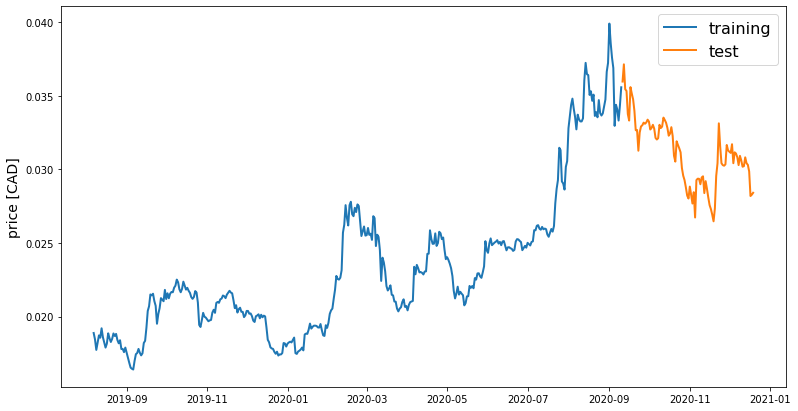

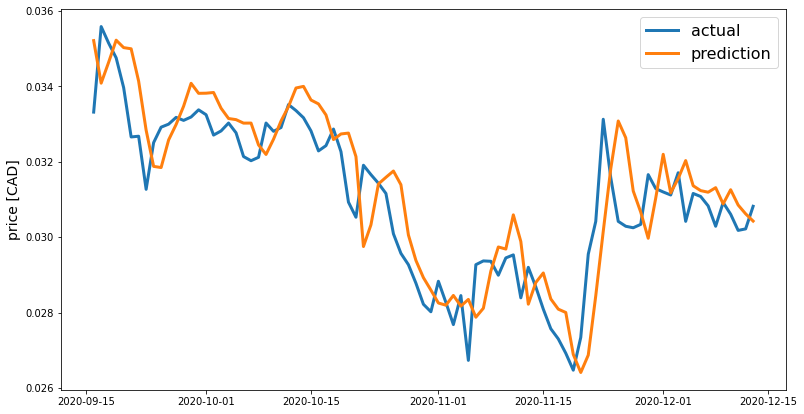

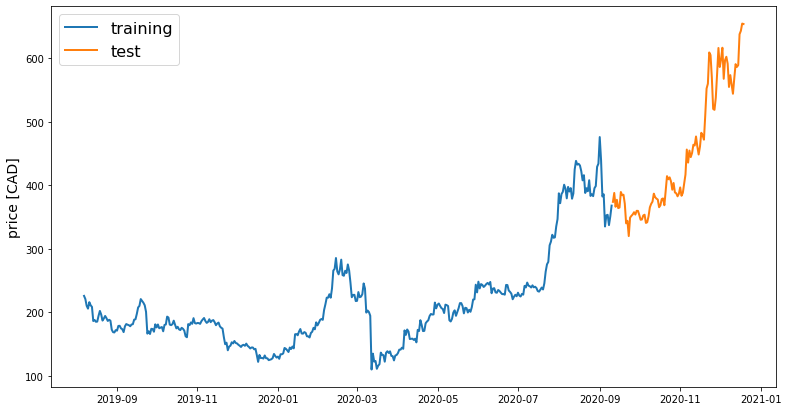

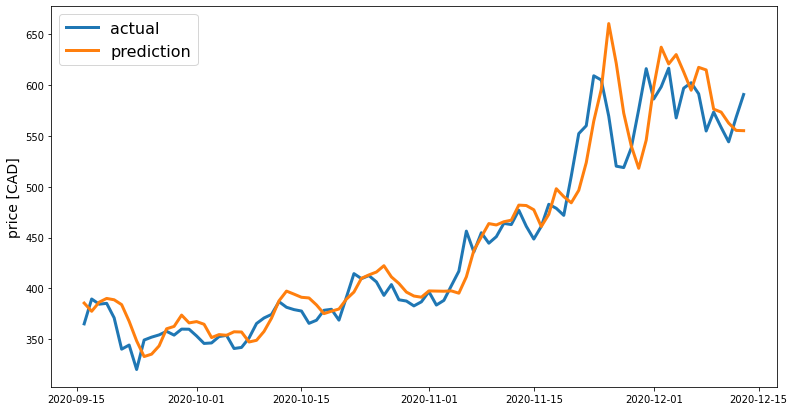

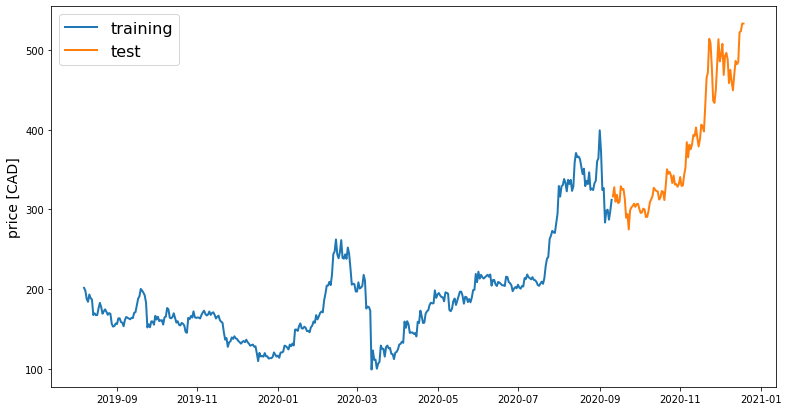

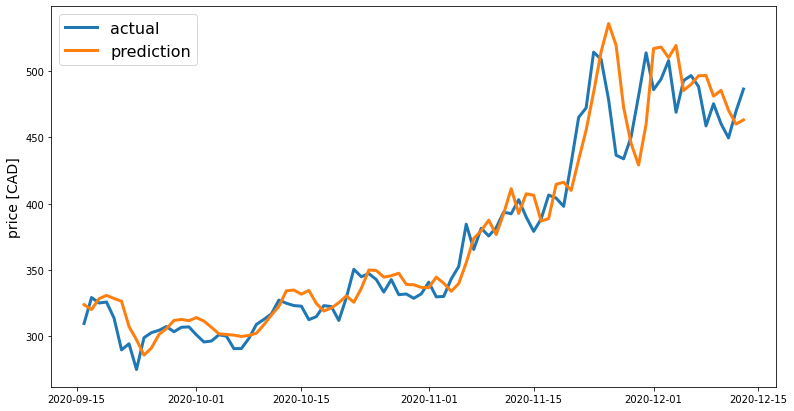

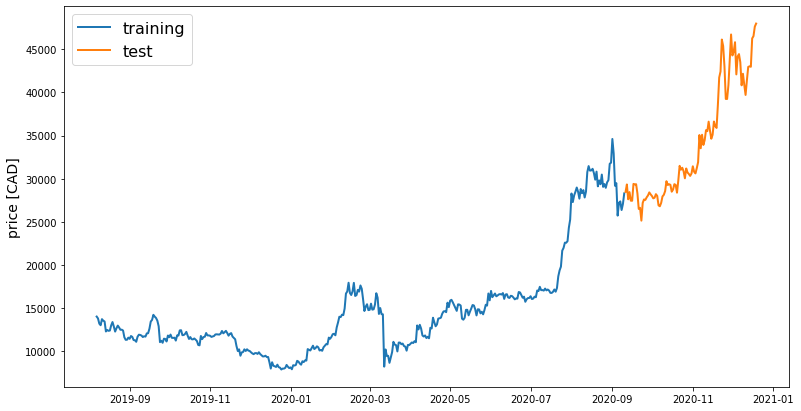

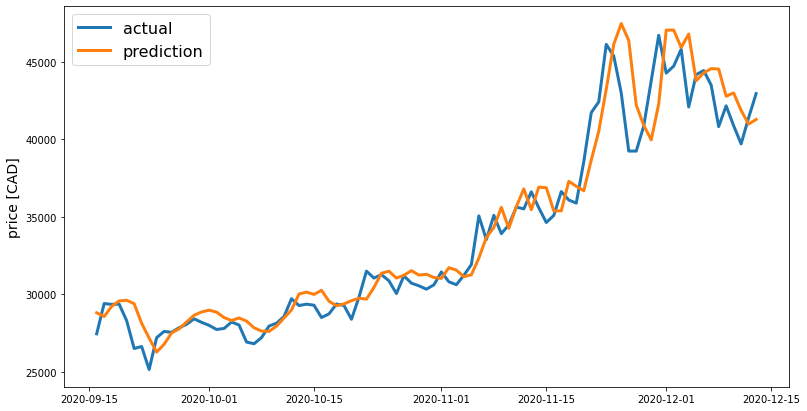

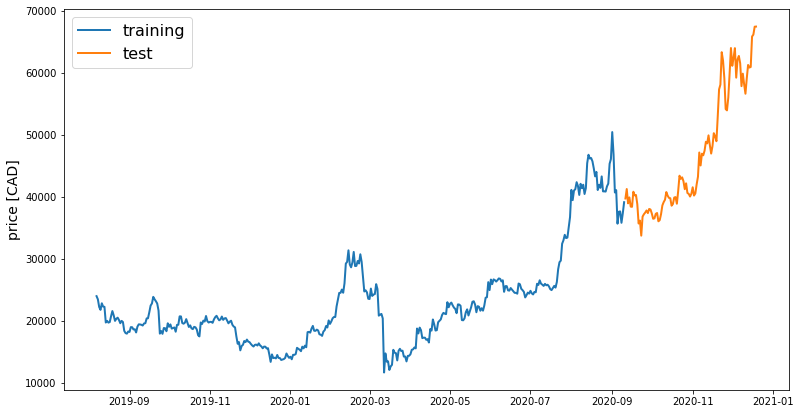

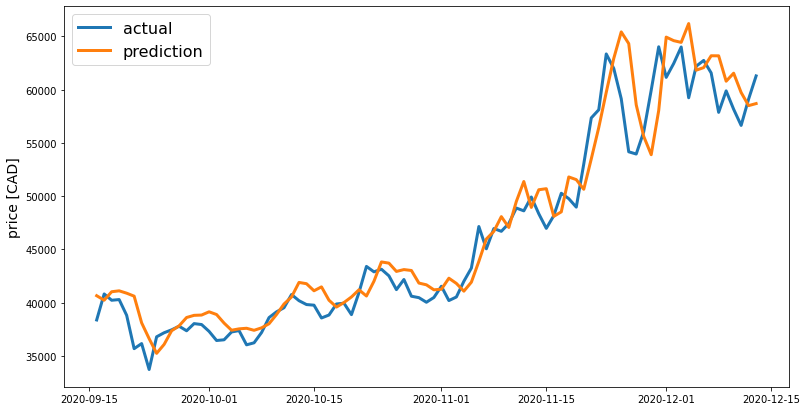

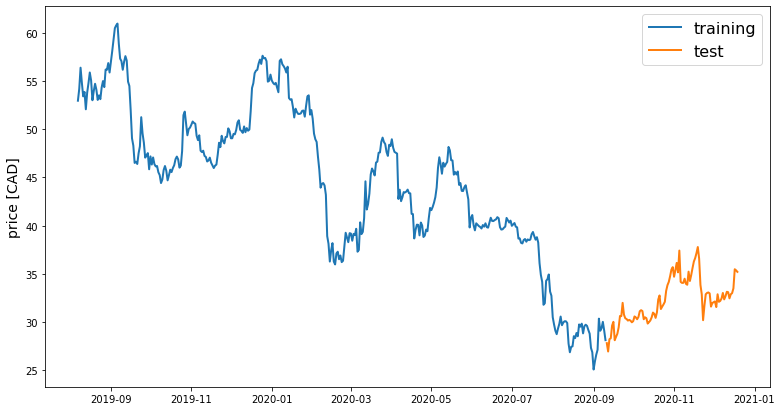

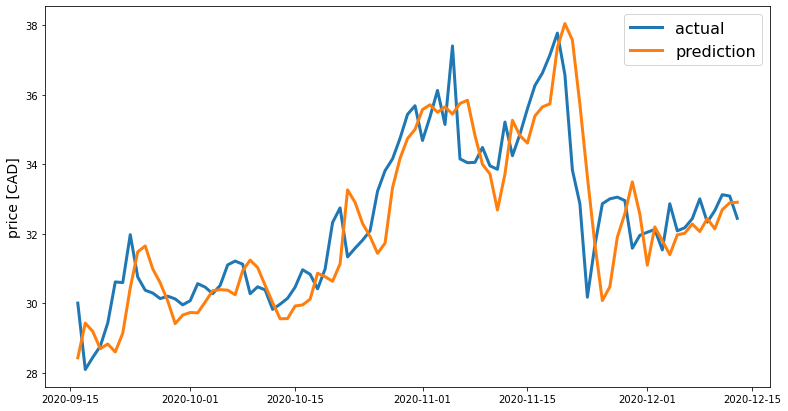

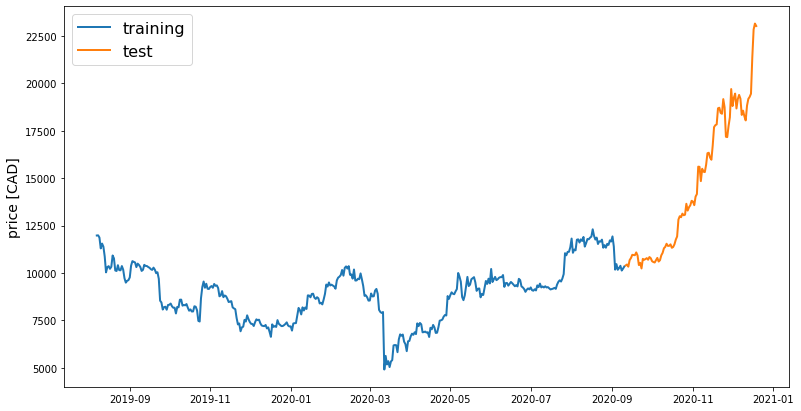

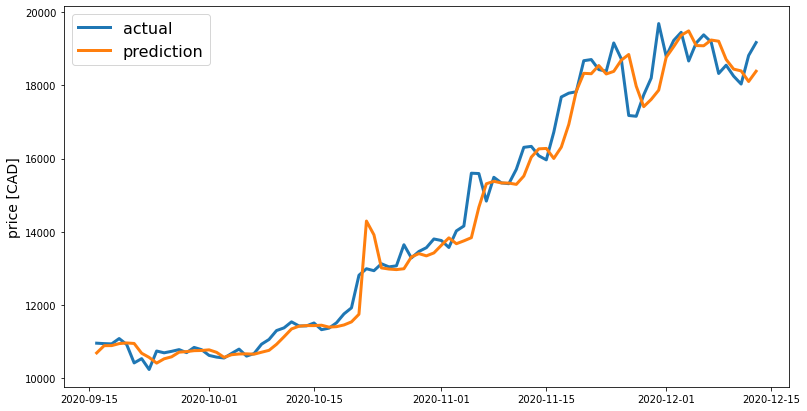

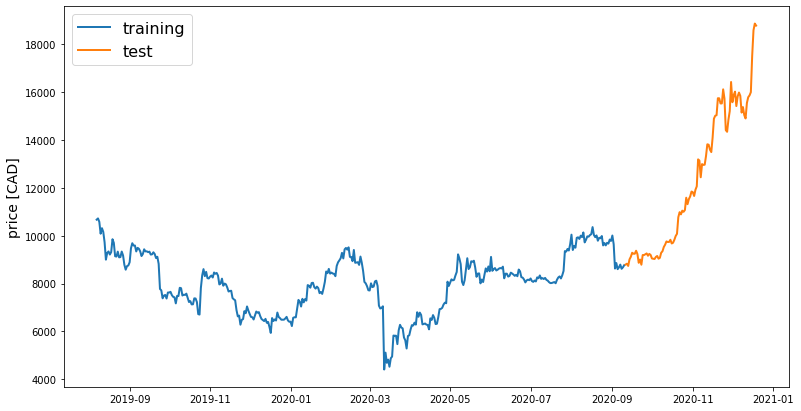

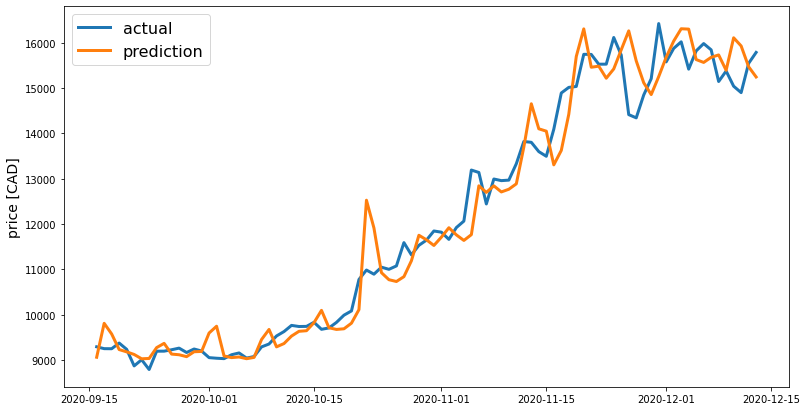

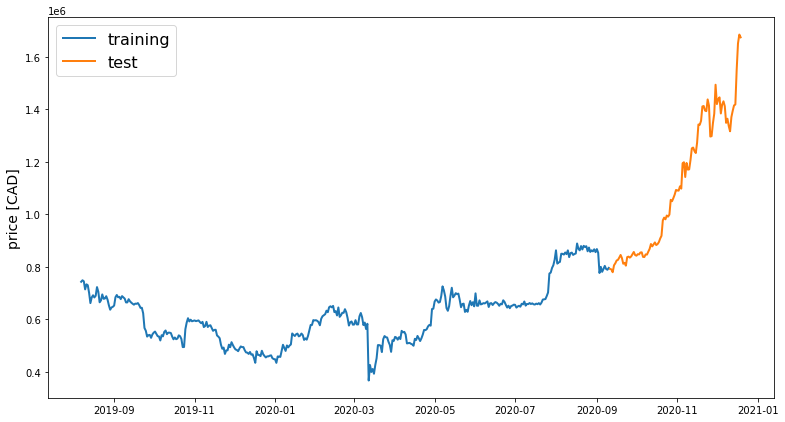

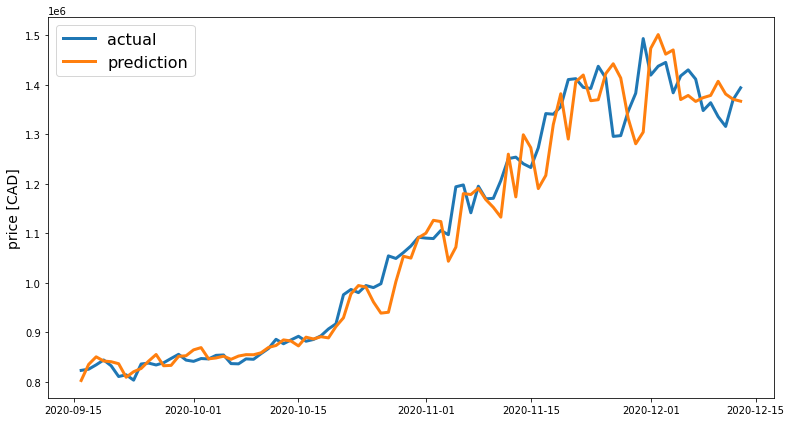

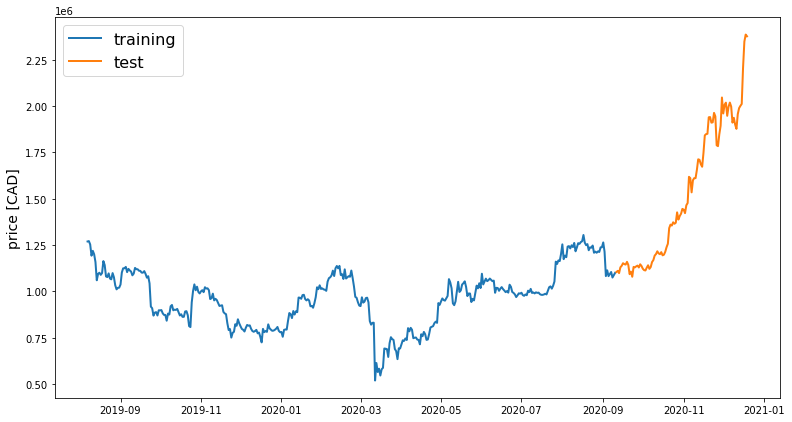

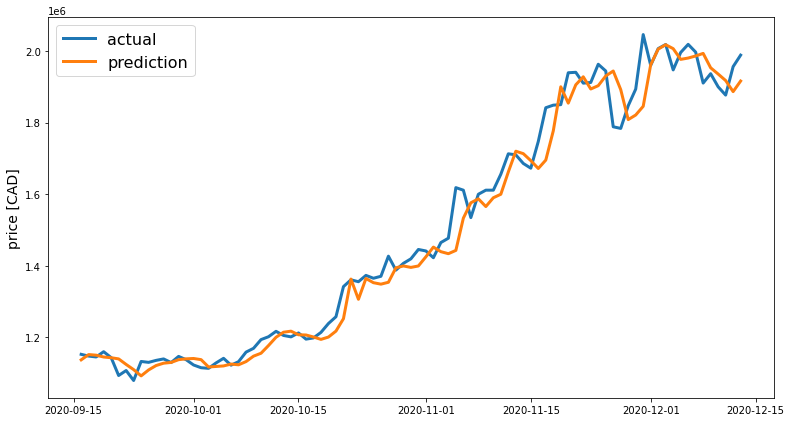

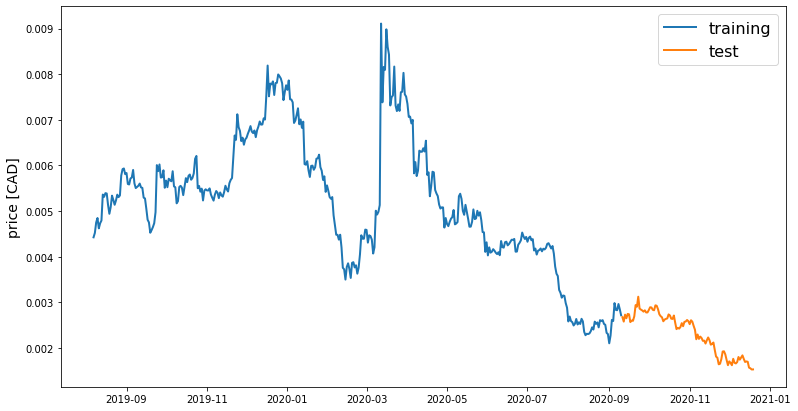

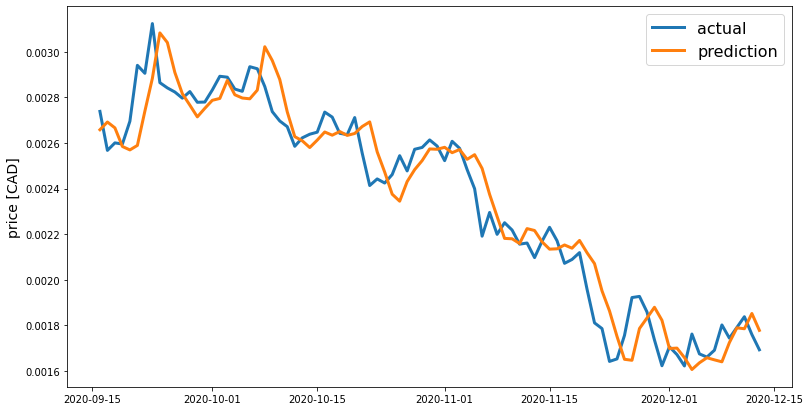

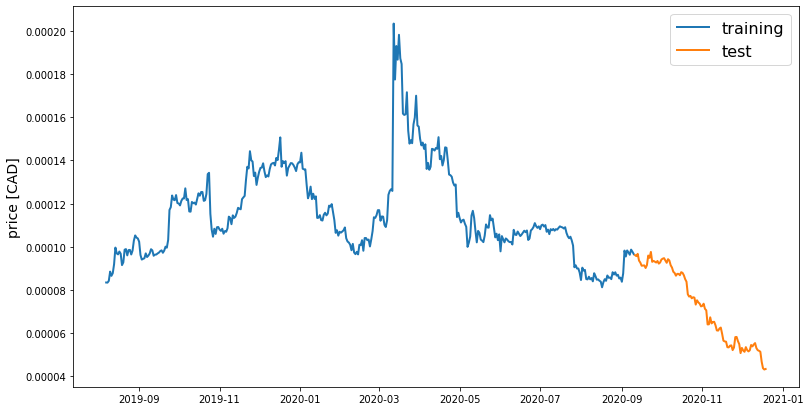

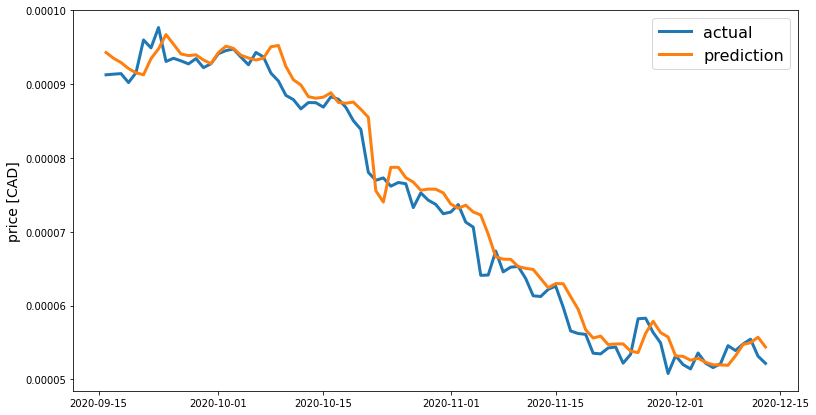

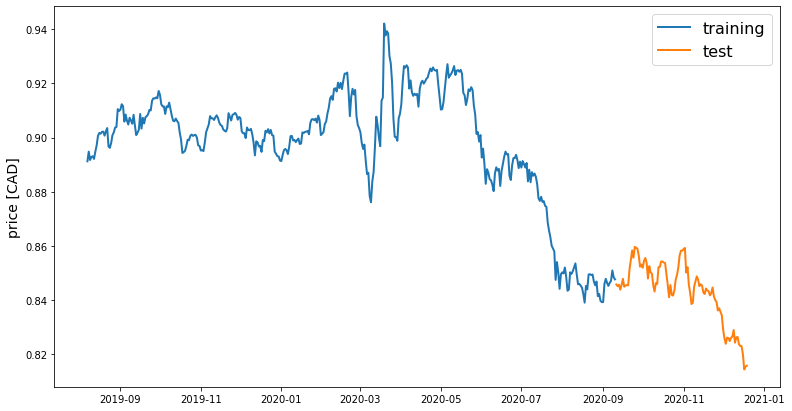

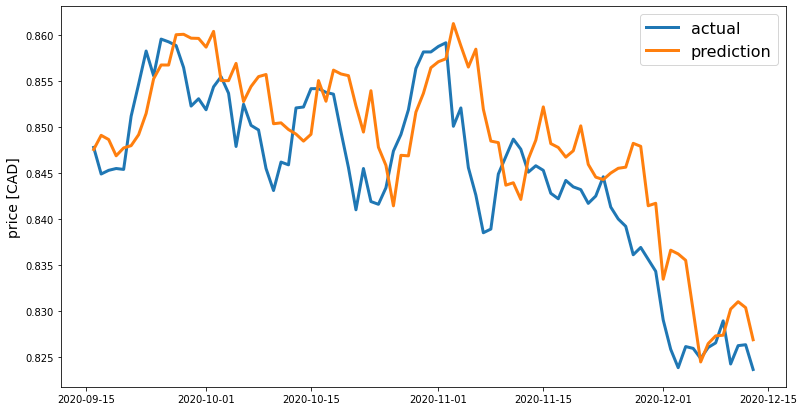

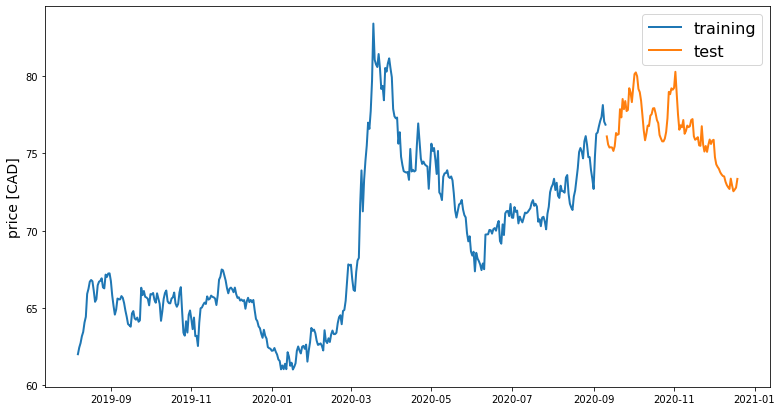

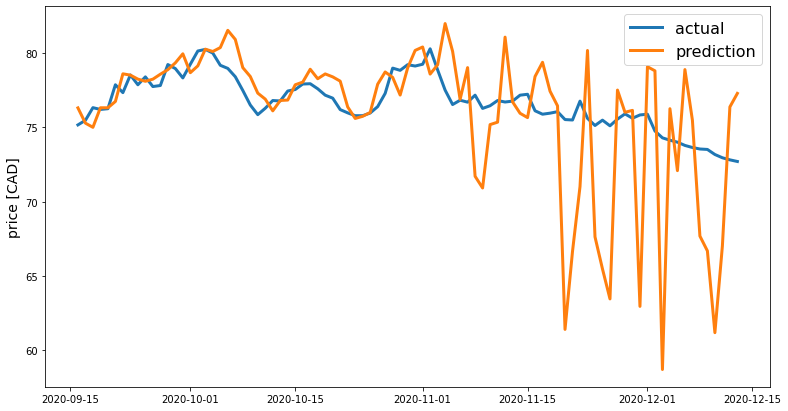

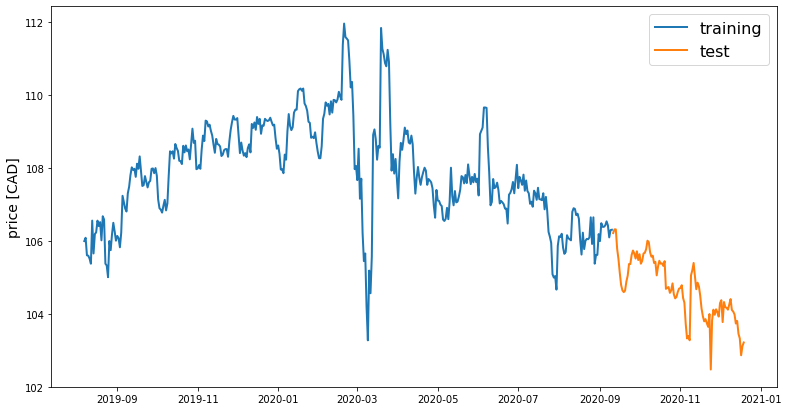

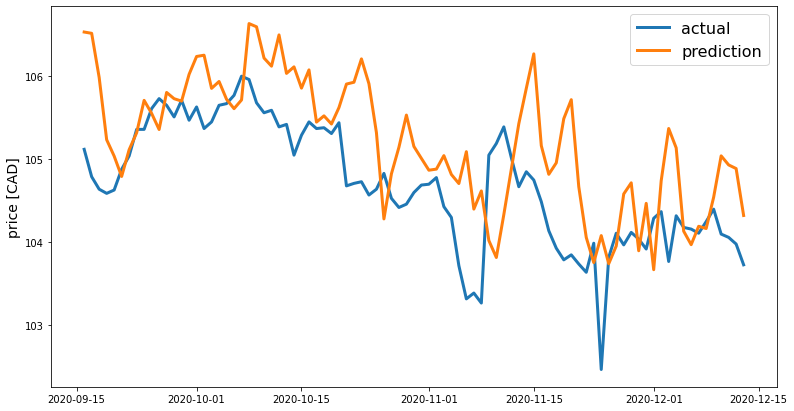

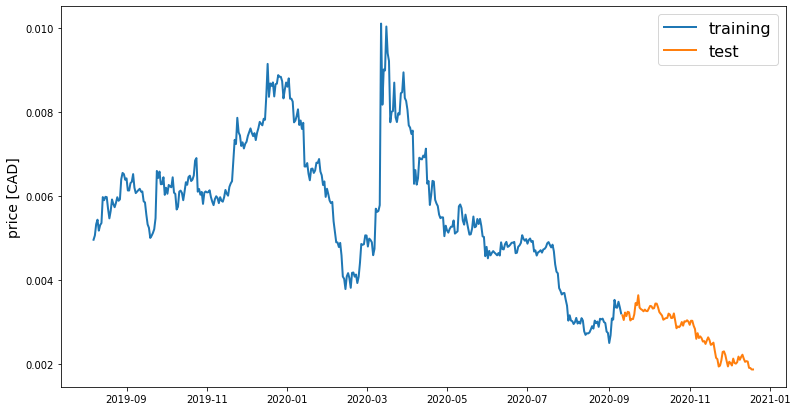

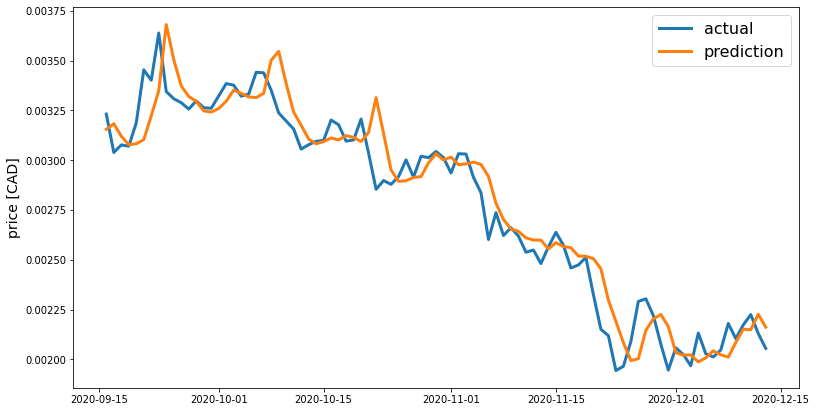

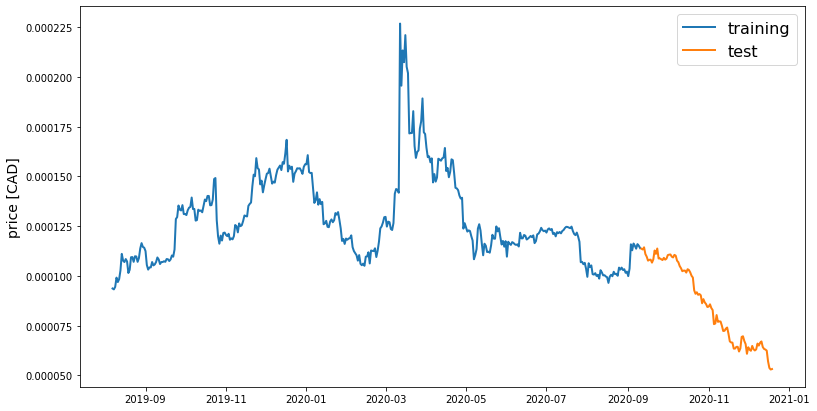

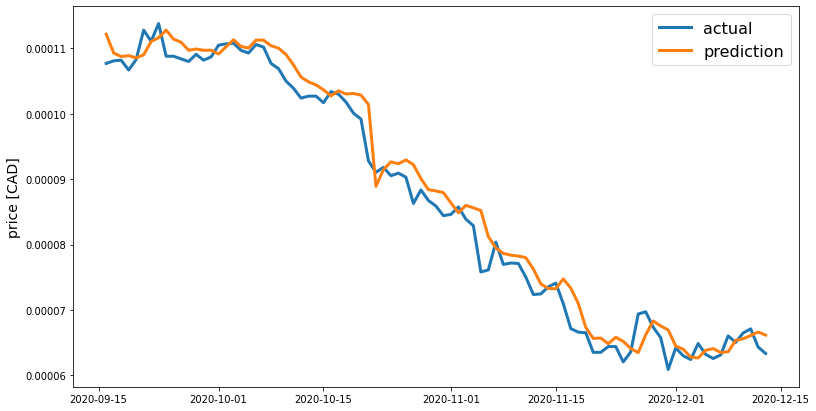

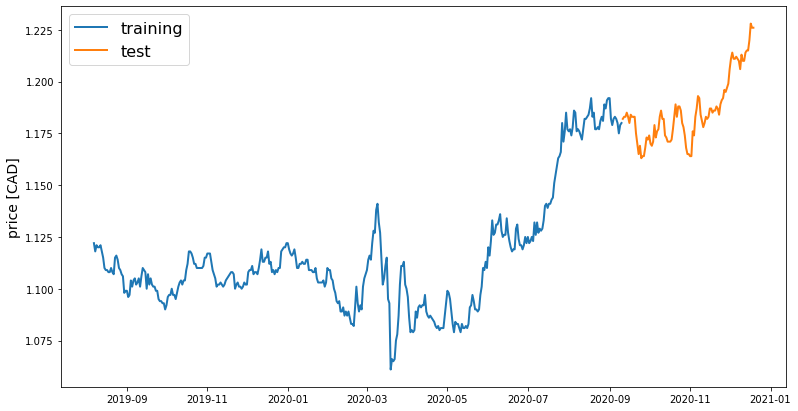

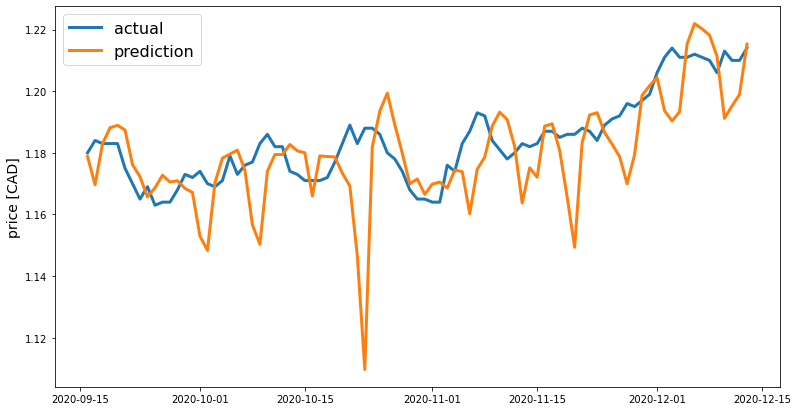

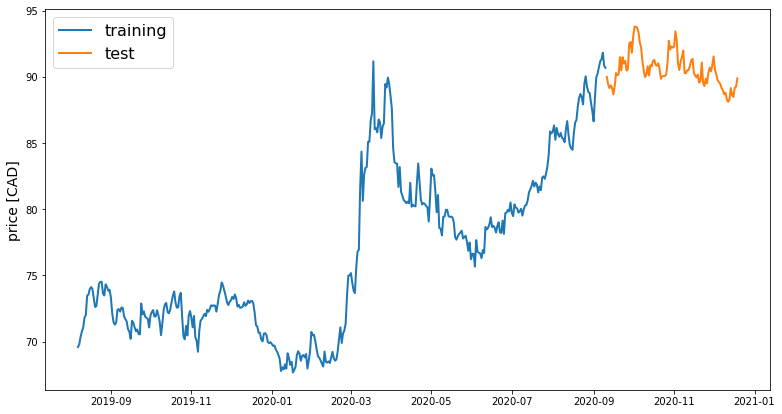

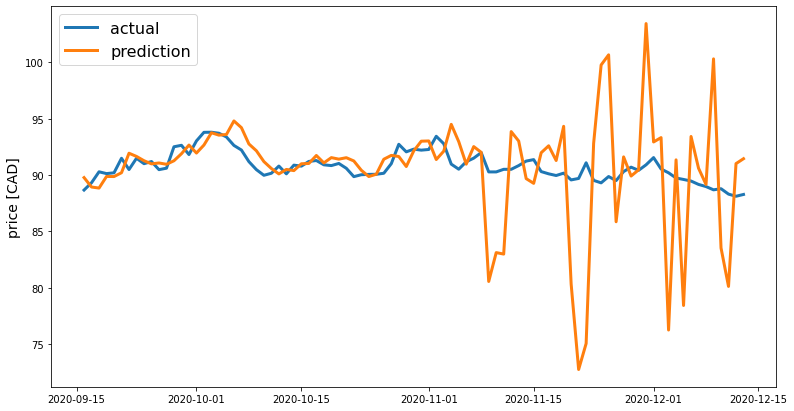

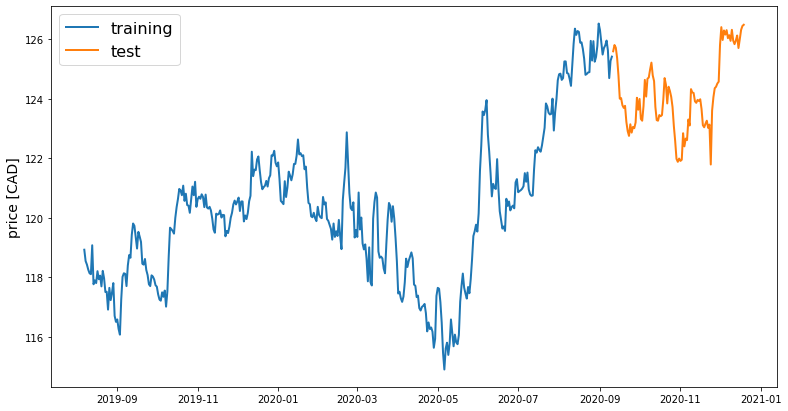

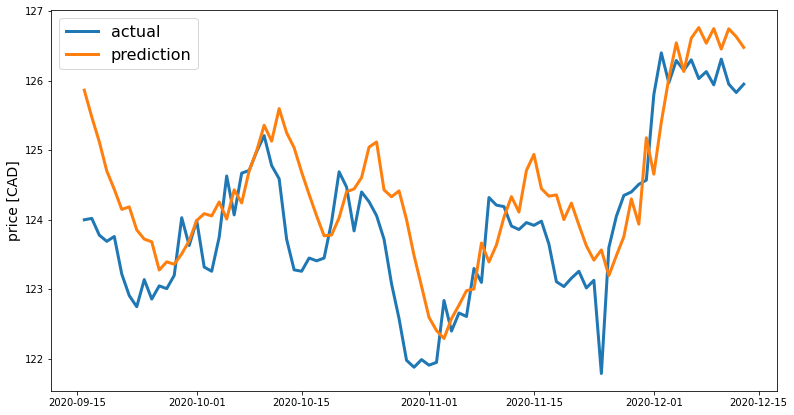

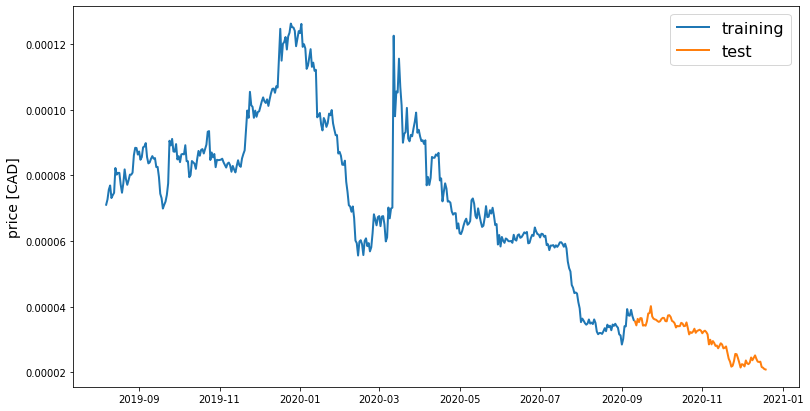

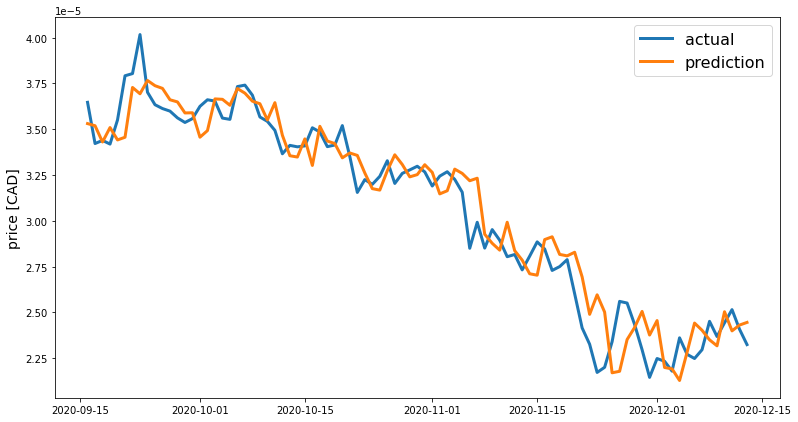

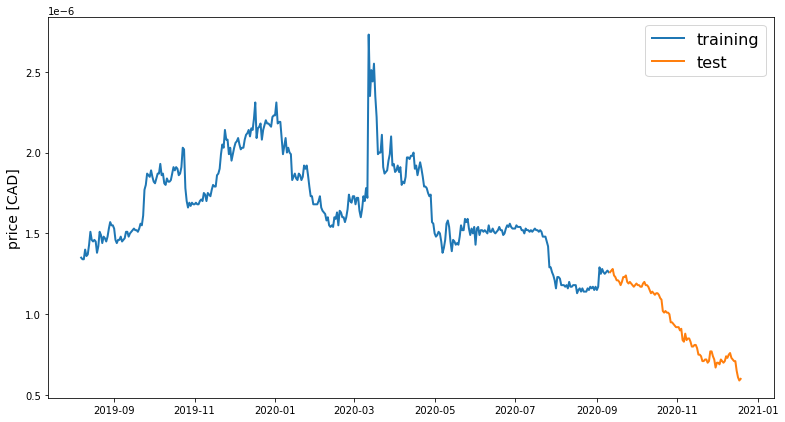

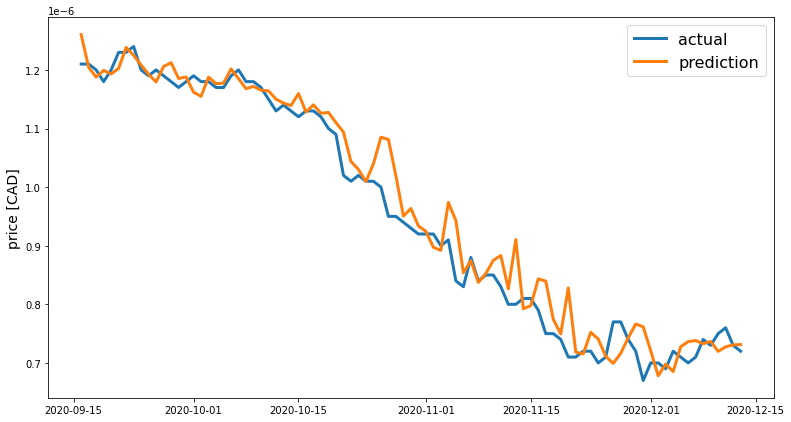

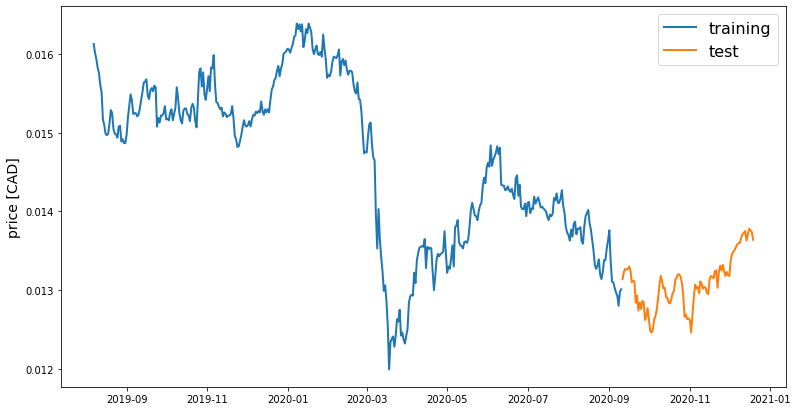

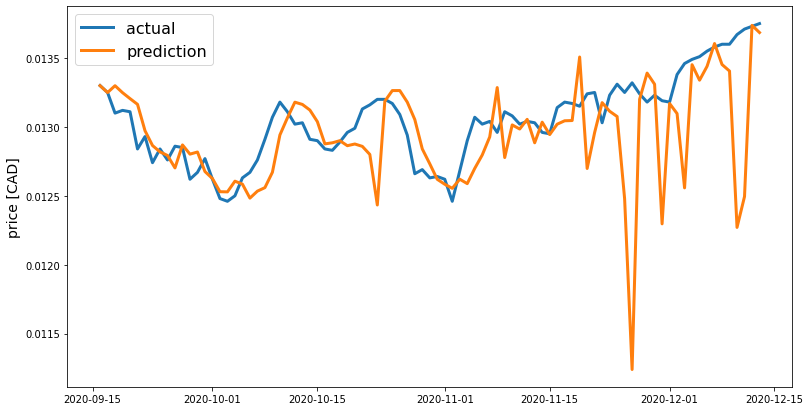

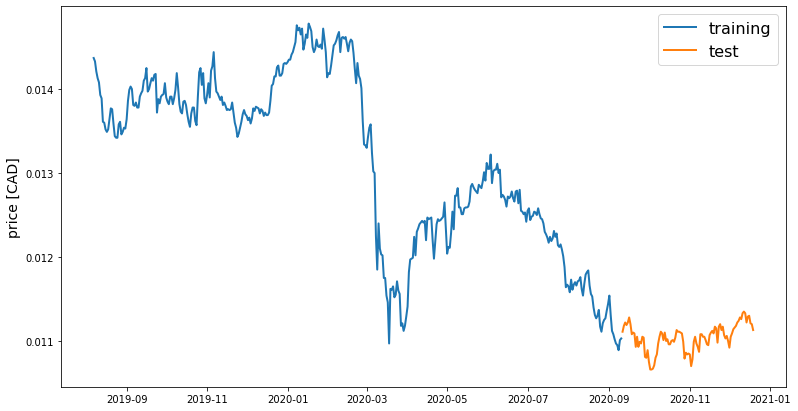

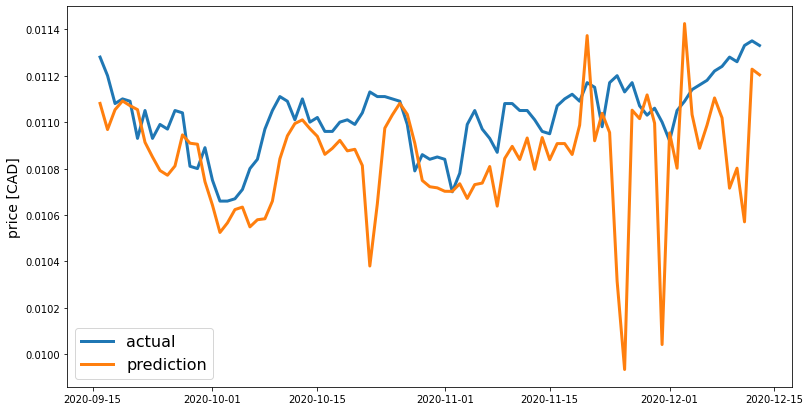

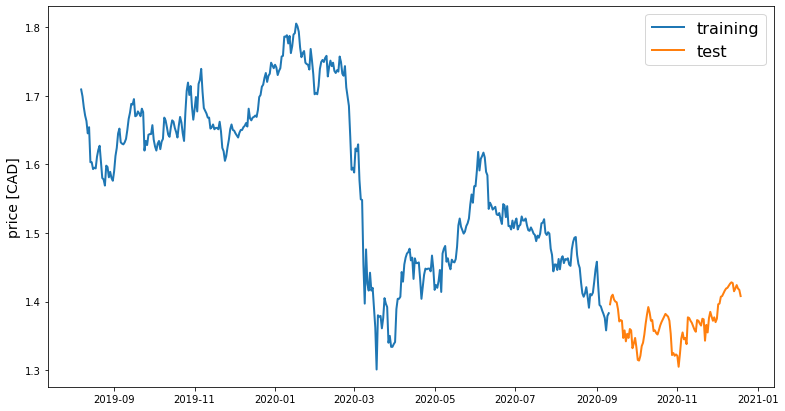

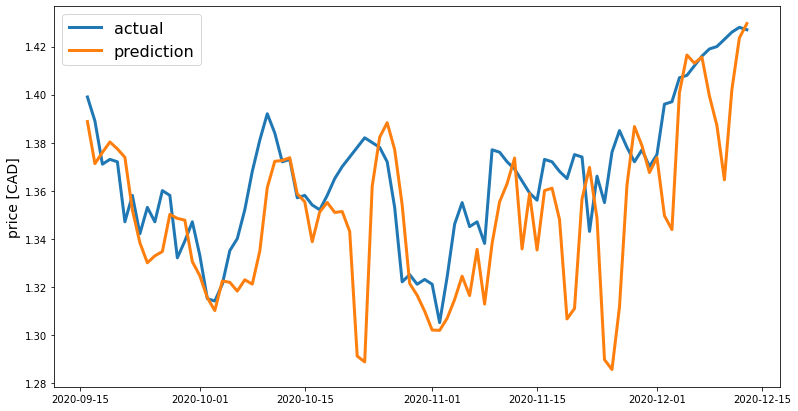

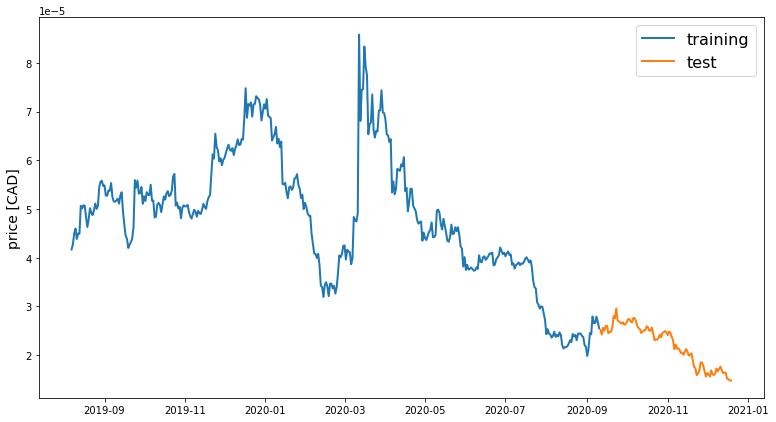

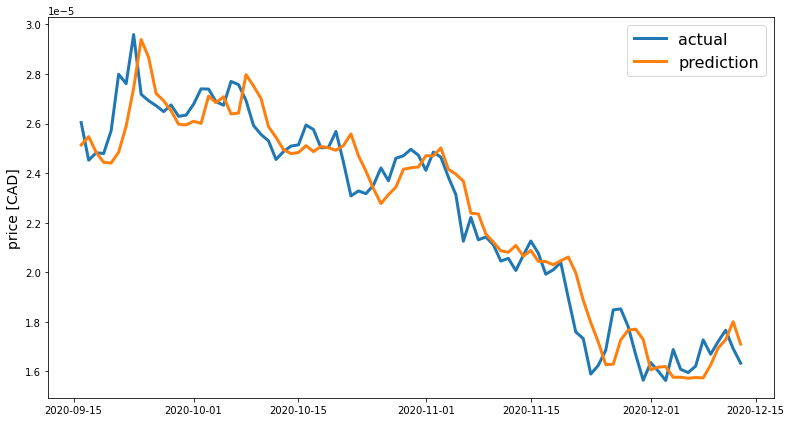

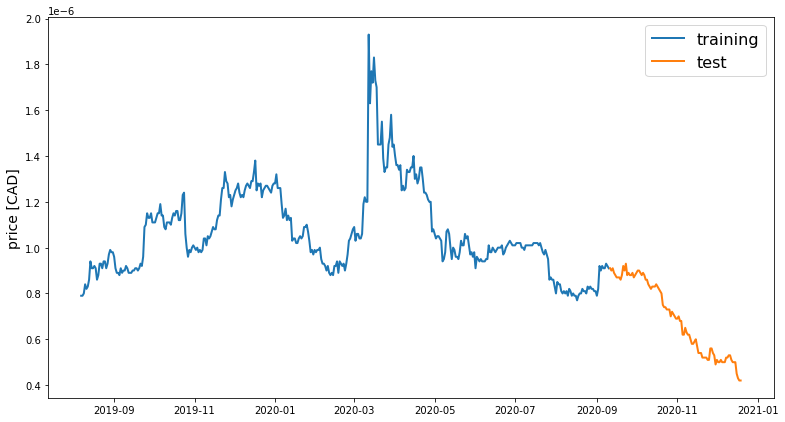

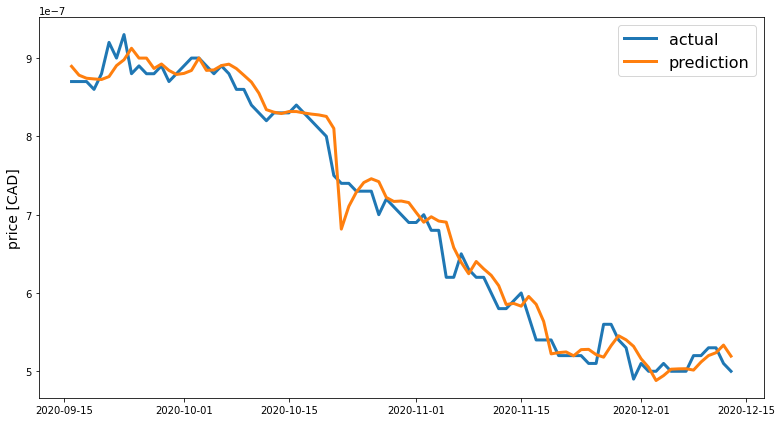

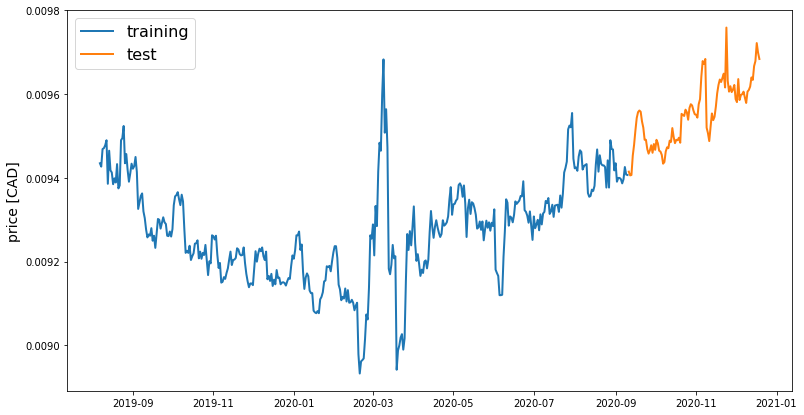

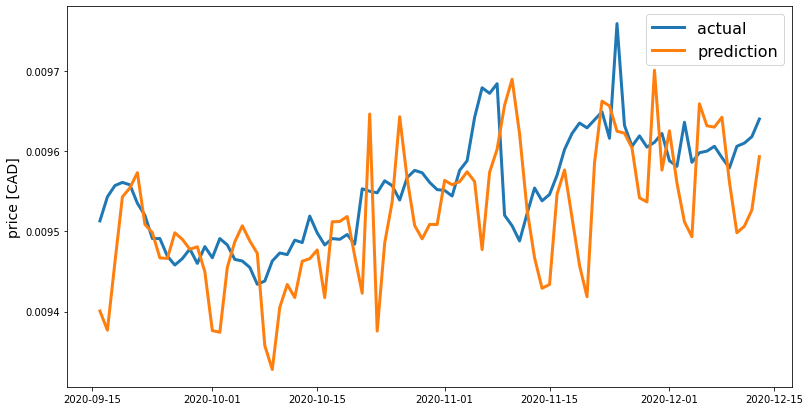

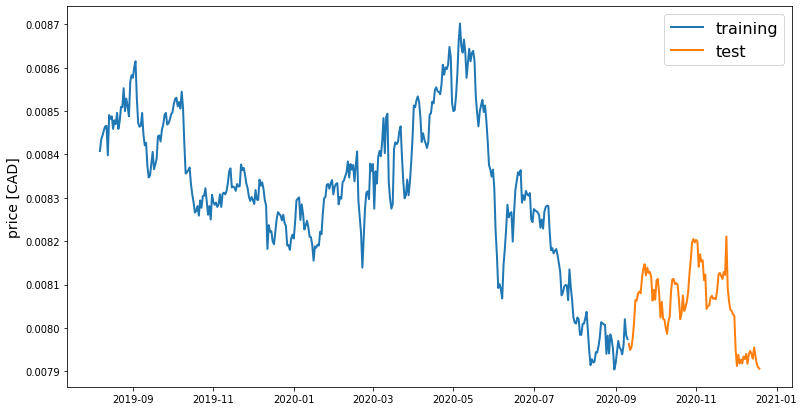

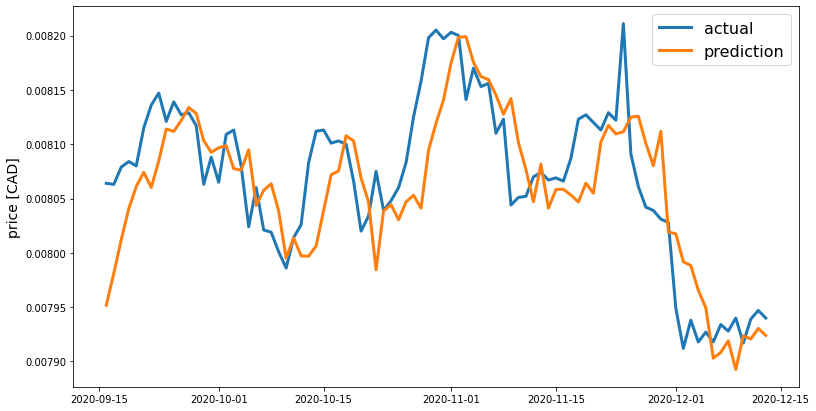

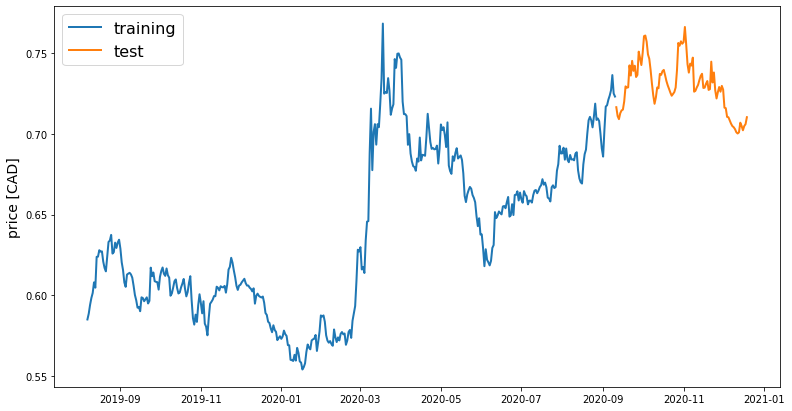

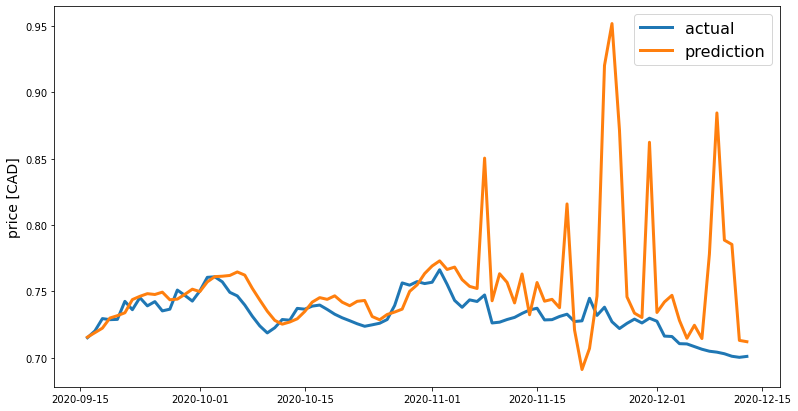

In [9]:
np.random.seed(42)
window_len = 5
pred_horizon = 6
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

curs = ['ETH', 'BTC', 'USD', 'EUR', 'RUB', 'JPY']

for icur in tqdm(curs):
  for outcur in curs:
    if (icur != outcur):
      endpoint = 'https://min-api.cryptocompare.com/data/histoday'
      res = requests.get(endpoint + '?fsym={}&tsym={}&limit=500'.format(icur, outcur))
      hist = pd.DataFrame(json.loads(res.content)['Data'])
      hist = hist.set_index('time')
      hist.index = pd.to_datetime(hist.index, unit='s')
      hist = hist[['high', 'low', 'open', 'volumefrom', 'volumeto', 'close']]
      target_col = 'close'
      print(hist.shape)
      print(hist.head(10))

      train, test = train_test_split(hist, test_size=0.2)
      # got train size 401 points, test size 100 points
      print(train.shape, test.shape)

      line_plot(train[target_col], test[target_col], 'training', 'test', title='')

      train, test, X_train, X_test, y_train, y_test, train_dates, test_dates = prepare_data(hist, target_col, 
                                                                                            window_len=window_len, 
                                                                                            pred_horizon=pred_horizon,
                                                                                            zero_base=zero_base, 
                                                                                            test_size=test_size)

      model = build_lstm_model( X_train, output_size=1, 
                              neurons=lstm_neurons, 
                              dropout=dropout, 
                              loss=loss, 
                              optimizer=optimizer)
      history = model.fit(X_train, y_train, epochs=epochs, 
                          batch_size=batch_size, verbose=1, shuffle=True)

      # save in h5
      # save_model(model, 'model_v1_lstm400.pkl')
      model.save('model_v1_lstm400_mod_win_7d_{}_{}.h5'.format(icur, outcur))

      # load from h5
      # model = load_model(model, 'model_v1_lstm400.pkl')
      model.load_weights('model_v1_lstm400_mod_win_7d_{}_{}.h5'.format(icur, outcur))

      # make inference
      targets = test[target_col][window_len:]
      preds = model.predict(X_test).squeeze()
      mean_absolute_error(preds, y_test)

      preds = test[target_col].values[:-window_len] * (preds + 1)
      preds = pd.Series(index=targets.index, data=preds)
      line_plot(targets, preds, 'actual', 'prediction', lw=3)